In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

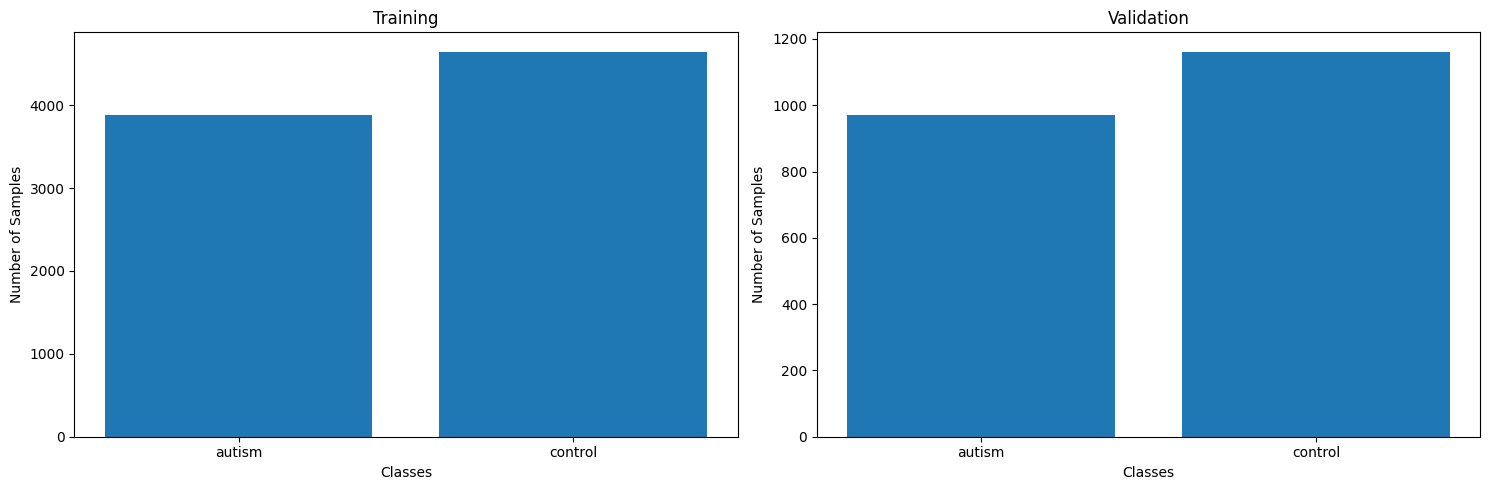

In [4]:
def plot_dataset_distribution(data_dir, title, axes):
    classes = ['autism', 'control']
    class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

    # Plot the dataset distribution on the provided axes
    axes.bar(class_counts.keys(), class_counts.values())
    axes.set_title(title)
    axes.set_xlabel('Classes')
    axes.set_ylabel('Number of Samples')

# Assuming you have 'train', 'test', and 'validate' folders in '/kaggle/input/abide1'
train_dir = '/kaggle/input/abideii/train'
val_dir = '/kaggle/input/abideii/val'

# Create a single row of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot dataset distribution for each split
plot_dataset_distribution(train_dir, 'Training', axes[0])
plot_dataset_distribution(val_dir, 'Validation', axes[1])

plt.tight_layout()
plt.show()


**Checking image dimensions**

In [9]:
image = cv2.imread("/kaggle/input/abideii/train/control/100228699-784.png")
print(image.shape)

(229, 220, 3)


# Data Augmentation

In [10]:
# Part 1 - Getting the data and defining parameters

from keras.preprocessing.image import ImageDataGenerator
input_size = (224, 224)

train_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)
training_set = train_datagen.flow_from_directory(r'/kaggle/input/abideii/train',
                                                 target_size = input_size,
                                                 class_mode = 'binary'
                                                 )

validation_set = train_datagen.flow_from_directory(r'/kaggle/input/abideii/val',
                                                 target_size = input_size,
                                                 class_mode = 'binary'
                                                 )

Found 8531 images belonging to 2 classes.
Found 2134 images belonging to 2 classes.


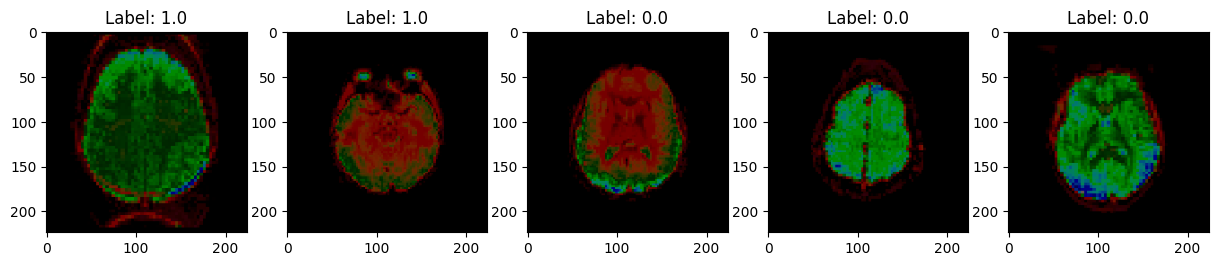

In [14]:
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))

for i in range(num_images_to_plot):
    # Get a batch of augmented images
    batch = training_set.next()

    # Extract the first image and label from the batch
    image = batch[0][0]
    label = batch[1][0]

    

    # Display the image and label
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')

plt.show()

In [15]:
image_names = training_set.filenames
labels = training_set.labels

for i in range(len(image_names)):
    print(f"Image Name: {image_names[i]}, Label: {labels[i]}")

Image Name: autism/100128679-208.png, Label: 0
Image Name: autism/100228679-208.png, Label: 0
Image Name: autism/100428675-753.png, Label: 0
Image Name: autism/100428679-208.png, Label: 0
Image Name: autism/100528675-753.png, Label: 0
Image Name: autism/100528679-208.png, Label: 0
Image Name: autism/100628675-753.png, Label: 0
Image Name: autism/100828675-753.png, Label: 0
Image Name: autism/100928675-753.png, Label: 0
Image Name: autism/100928679-208.png, Label: 0
Image Name: autism/101028679-208.png, Label: 0
Image Name: autism/101128675-754.png, Label: 0
Image Name: autism/101128682-209.png, Label: 0
Image Name: autism/101228675-754.png, Label: 0
Image Name: autism/101228682-209.png, Label: 0
Image Name: autism/101328675-754.png, Label: 0
Image Name: autism/101428675-754.png, Label: 0
Image Name: autism/101428682-209.png, Label: 0
Image Name: autism/101528675-754.png, Label: 0
Image Name: autism/101528682-209.png, Label: 0
Image Name: autism/101628675-754.png, Label: 0
Image Name: a

# Transfer learning
Resnet50->imagnet

In [16]:
input_size = (224, 224, 3)

resnet = ResNet50(weights='/kaggle/input/resnet50notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False,input_shape=input_size)

In [17]:
for layer in resnet.layers:
    layer.trainable = False

model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
# model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(128,activation='relu')(model)
# model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(64,activation='relu')(model)
model = tf.keras.layers.Dense(1,activation='sigmoid')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [19]:
base_learning_rate = 0.001
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics= ['accuracy'])

In [20]:
# tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/kaggle/working/resnet50",monitor="val_accuracy",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 2, min_delta = 0.001,verbose=1)

In [22]:
initial_epochs = 5

history = model.fit(
    training_set,
    # steps_per_epoch=training_set.n // 32,
    validation_data=validation_set,
    # validation_steps = validation_set.n // 32,
    epochs=initial_epochs, verbose=1, batch_size=32,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/5
267/267 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.5355
Epoch 1: val_accuracy improved from -inf to 0.54452, saving model to /kaggle/working/resnet50
267/267 [==============================] - 888s 3s/step - loss: 0.6947 - accuracy: 0.5355 - val_loss: 0.6894 - val_accuracy: 0.5445 - lr: 0.0010
Epoch 2/5
267/267 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.5416
Epoch 2: val_accuracy did not improve from 0.54452
267/267 [==============================] - 897s 3s/step - loss: 0.6901 - accuracy: 0.5416 - val_loss: 0.6882 - val_accuracy: 0.5445 - lr: 0.0010
Epoch 3/5
263/267 [============================>.] - ETA: 10s - loss: 0.6896 - accuracy: 0.5410

KeyboardInterrupt: 

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning